In [33]:
%%time
import os
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

CPU times: user 424 µs, sys: 6 µs, total: 430 µs
Wall time: 427 µs


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/geometrein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/geometrein/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geometrein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
%%time
year = 2021
path = os.path.join('data', f'news_headlines_en_{year}.csv')
source_df = pd.read_csv(path, sep='\t')
source_df.sample(10)

CPU times: user 9.41 ms, sys: 2.01 ms, total: 11.4 ms
Wall time: 10 ms


,date,headline,link
496,2021-03-16 14:09:50,Nationalist organisation chair stands trial fo...,https://yle.fi/uutiset/osasto/news/nationalist...
596,2021-03-30 10:26:24,STM: Decision on priority vaccinations to come...,https://yle.fi/uutiset/osasto/news/stm_decisio...
1609,2021-08-27 16:00:04,Pirkanmaa's 2-metre distancing rules to expire...,https://yle.fi/uutiset/osasto/news/pirkanmaas_...
1873,2021-10-06 15:12:23,Planning for high speed Helsinki-Turku train m...,https://yle.fi/uutiset/osasto/news/planning_fo...
1918,2021-10-12 13:23:47,Culture sport and science sectors facing 15% f...,https://yle.fi/uutiset/osasto/news/culture_spo...
1878,2021-10-07 09:06:41,Good morning everyone! ☀️The creator of this c...,https://dashmap.io/
335,2021-02-21 16:42:19,PM: Return to upper secondary contact teaching...,https://yle.fi/uutiset/osasto/news/pm_return_t...
977,2021-05-19 17:06:11,OECD: Finland must cut red tape to attract mor...,https://yle.fi/uutiset/osasto/news/oecd_finlan...
500,2021-03-16 17:40:48,Coronavirus infections increasing among under-...,https://yle.fi/uutiset/osasto/news/coronavirus...
917,2021-05-11 16:29:27,Finland sees summer temperatures on spring's w...,https://yle.fi/uutiset/osasto/news/finland_see...


In [35]:
%%time
def pre_process_data(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df['date'])
    # Convert to lowercase
    df['headline'] = df['headline'].str.lower()
    # Tokenize
    df['headline_token'] = df['headline'].apply(word_tokenize)
    # Load and remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    df['headline_token'] = df['headline_token'].apply(lambda x: [item for item in x if item not in stopwords])
    # Remove punctuation
    df['headline_token'] = df['headline_token'].apply(lambda x: [item for item in x if item.isalpha()])
    return df

clean_df = pre_process_data(source_df)
clean_df

CPU times: user 212 ms, sys: 3.46 ms, total: 216 ms
Wall time: 220 ms


,date,headline,link,headline_token
0,2021-01-04 10:55:30,more cases of new coronavirus variant found in...,https://yle.fi/uutiset/osasto/news/more_cases_...,"[cases, new, coronavirus, variant, found, finl..."
1,2021-01-04 14:56:05,children of bodom founding guitarist laiho die...,https://yle.fi/uutiset/osasto/news/children_of...,"[children, bodom, founding, guitarist, laiho, ..."
2,2021-01-04 16:36:12,lapland police wrap up fatal hunting accident ...,https://yle.fi/uutiset/osasto/news/lapland_pol...,"[lapland, police, wrap, fatal, hunting, accide..."
3,2021-01-04 18:46:32,police detain 15-year-old in helsinki stabbing...,https://yle.fi/uutiset/osasto/news/police_deta...,"[police, detain, helsinki, stabbing, incident]"
4,2021-01-04 20:16:43,vr to launch joint ticketing with local buses ...,https://yle.fi/uutiset/osasto/news/vr_to_launc...,"[vr, launch, joint, ticketing, local, buses, t..."
...,...,...,...,...
2382,2021-12-30 11:22:48,helsinki after school clubs to be held outdoor...,https://yle.fi/news/3-12251625,"[helsinki, school, clubs, held, outdoors, janu..."
2383,2021-12-30 13:03:52,justice minister henriksson tests positive for...,https://yle.fi/news/3-12252020,"[justice, minister, henriksson, tests, positiv..."
2384,2021-12-30 13:53:23,citizens' initiative banning non-professional ...,https://yle.fi/news/3-12252167,"[citizens, initiative, banning, use, fireworks..."
2385,2021-12-30 16:44:07,finland prepares for muted new year celebratio...,https://yle.fi/news/3-12252650,"[finland, prepares, muted, new, year, celebrat..."


# Unsupervised Sentiment Analysis with VADER
---

In [36]:
def get_sentiments(df: pd.DataFrame) -> pd.DataFrame:
    sa_model = SentimentIntensityAnalyzer()
    df['polarity'] = df['headline'].apply(lambda x: sa_model.polarity_scores(x))
    final_df = pd.concat([df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
    return final_df

df = get_sentiments(df=clean_df)
df

,date,headline,link,headline_token,neg,neu,pos,compound
0,2021-01-04 10:55:30,more cases of new coronavirus variant found in...,https://yle.fi/uutiset/osasto/news/more_cases_...,"[cases, new, coronavirus, variant, found, finl...",0.000,1.000,0.000,0.0000
1,2021-01-04 14:56:05,children of bodom founding guitarist laiho die...,https://yle.fi/uutiset/osasto/news/children_of...,"[children, bodom, founding, guitarist, laiho, ...",0.000,1.000,0.000,0.0000
2,2021-01-04 16:36:12,lapland police wrap up fatal hunting accident ...,https://yle.fi/uutiset/osasto/news/lapland_pol...,"[lapland, police, wrap, fatal, hunting, accide...",0.524,0.476,0.000,-0.7650
3,2021-01-04 18:46:32,police detain 15-year-old in helsinki stabbing...,https://yle.fi/uutiset/osasto/news/police_deta...,"[police, detain, helsinki, stabbing, incident]",0.318,0.682,0.000,-0.4215
4,2021-01-04 20:16:43,vr to launch joint ticketing with local buses ...,https://yle.fi/uutiset/osasto/news/vr_to_launc...,"[vr, launch, joint, ticketing, local, buses, t...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
2382,2021-12-30 11:22:48,helsinki after school clubs to be held outdoor...,https://yle.fi/news/3-12251625,"[helsinki, school, clubs, held, outdoors, janu...",0.000,1.000,0.000,0.0000
2383,2021-12-30 13:03:52,justice minister henriksson tests positive for...,https://yle.fi/news/3-12252020,"[justice, minister, henriksson, tests, positiv...",0.000,0.417,0.583,0.7906
2384,2021-12-30 13:53:23,citizens' initiative banning non-professional ...,https://yle.fi/news/3-12252167,"[citizens, initiative, banning, use, fireworks...",0.182,0.818,0.000,-0.2500
2385,2021-12-30 16:44:07,finland prepares for muted new year celebratio...,https://yle.fi/news/3-12252650,"[finland, prepares, muted, new, year, celebrat...",0.000,1.000,0.000,0.0000


In [37]:
daily_df = df.groupby([pd.Grouper(key='date', freq='D')])['compound'].sum().reset_index()
weekly_df = df.groupby([pd.Grouper(key='date', freq='W')])['compound'].sum().reset_index()
monthly_df = df.groupby([pd.Grouper(key='date', freq='M')])['compound'].sum().reset_index()

In [38]:
daily_df['simple_moving_avg'] = daily_df['compound'].rolling(7).mean()
weekly_df['simple_moving_avg'] = weekly_df['compound'].rolling(4).mean()

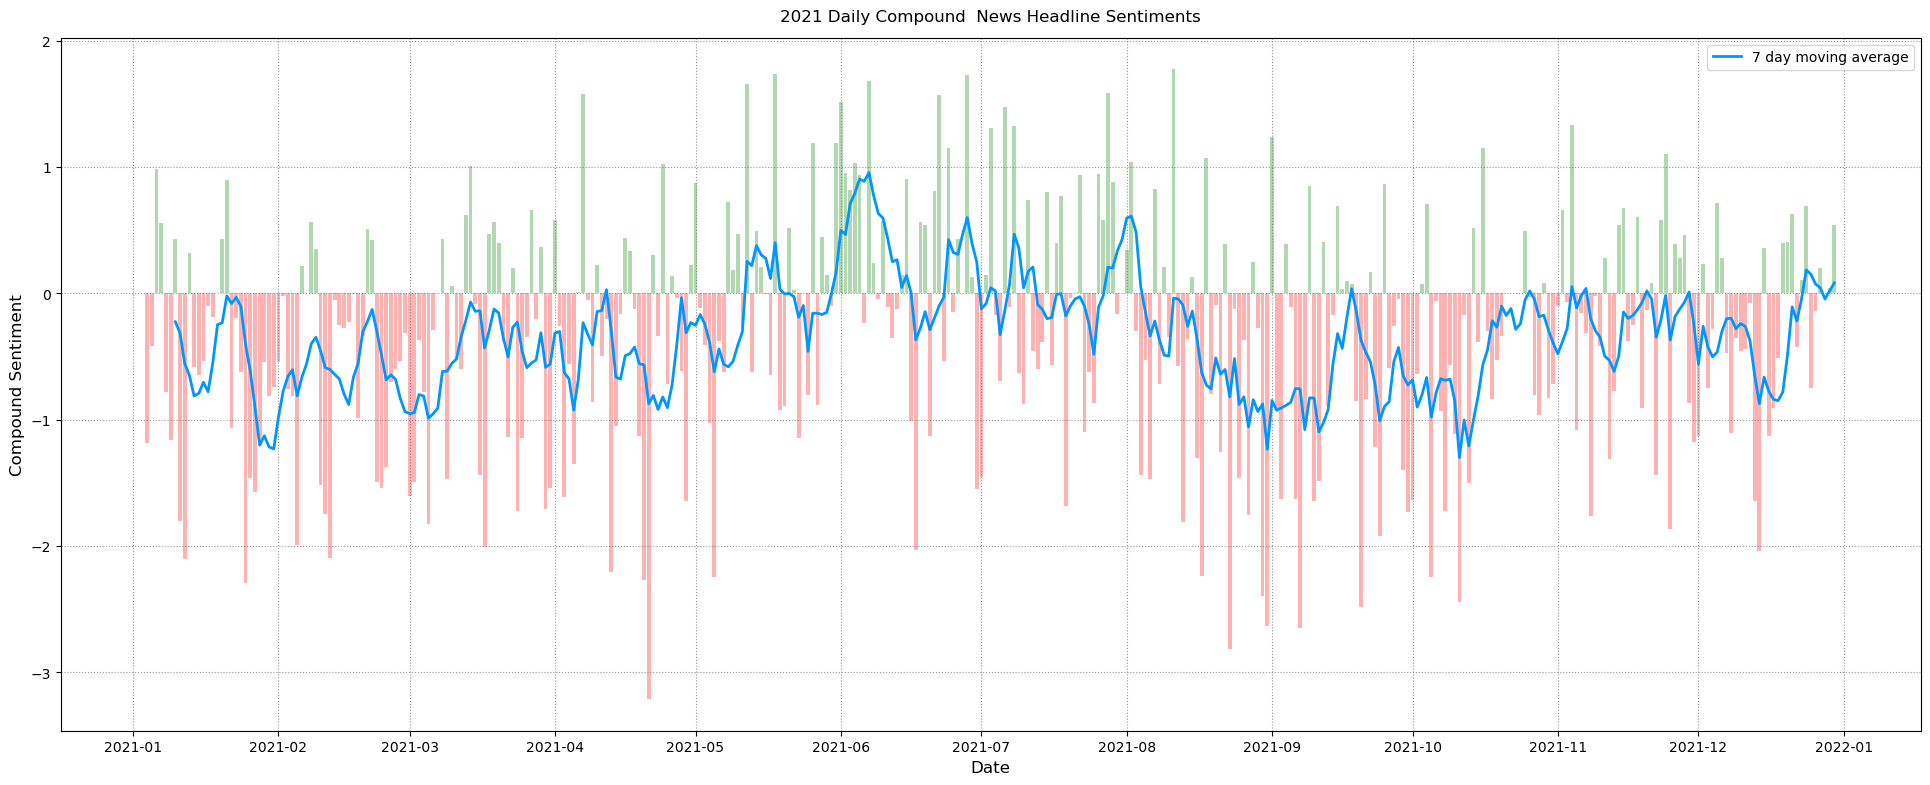

In [39]:
def plot_daily_compound_sentiments(daily_df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(24, 9), facecolor='w')

    ax.plot(daily_df['date'], daily_df['simple_moving_avg'], color='#0096FF', marker='', linestyle='-',linewidth=2, markersize=12, alpha=1) #2AAA8A
    color = ['r' if y < 0 else 'g' for y in daily_df['compound'].to_list()]
    ax.bar(daily_df['date'], daily_df['compound'], alpha=0.3, color=color)

    ax.set_title( f'{2021} Daily Compound  News Headline Sentiments', fontsize=12, pad=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Compound Sentiment', fontsize=12)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    # Legend & Grid
    ax.legend(['7 day moving average'])
    ax.grid(linestyle=':', color='#696969', alpha=0.7)

    plt.show()

plot_daily_compound_sentiments(daily_df)

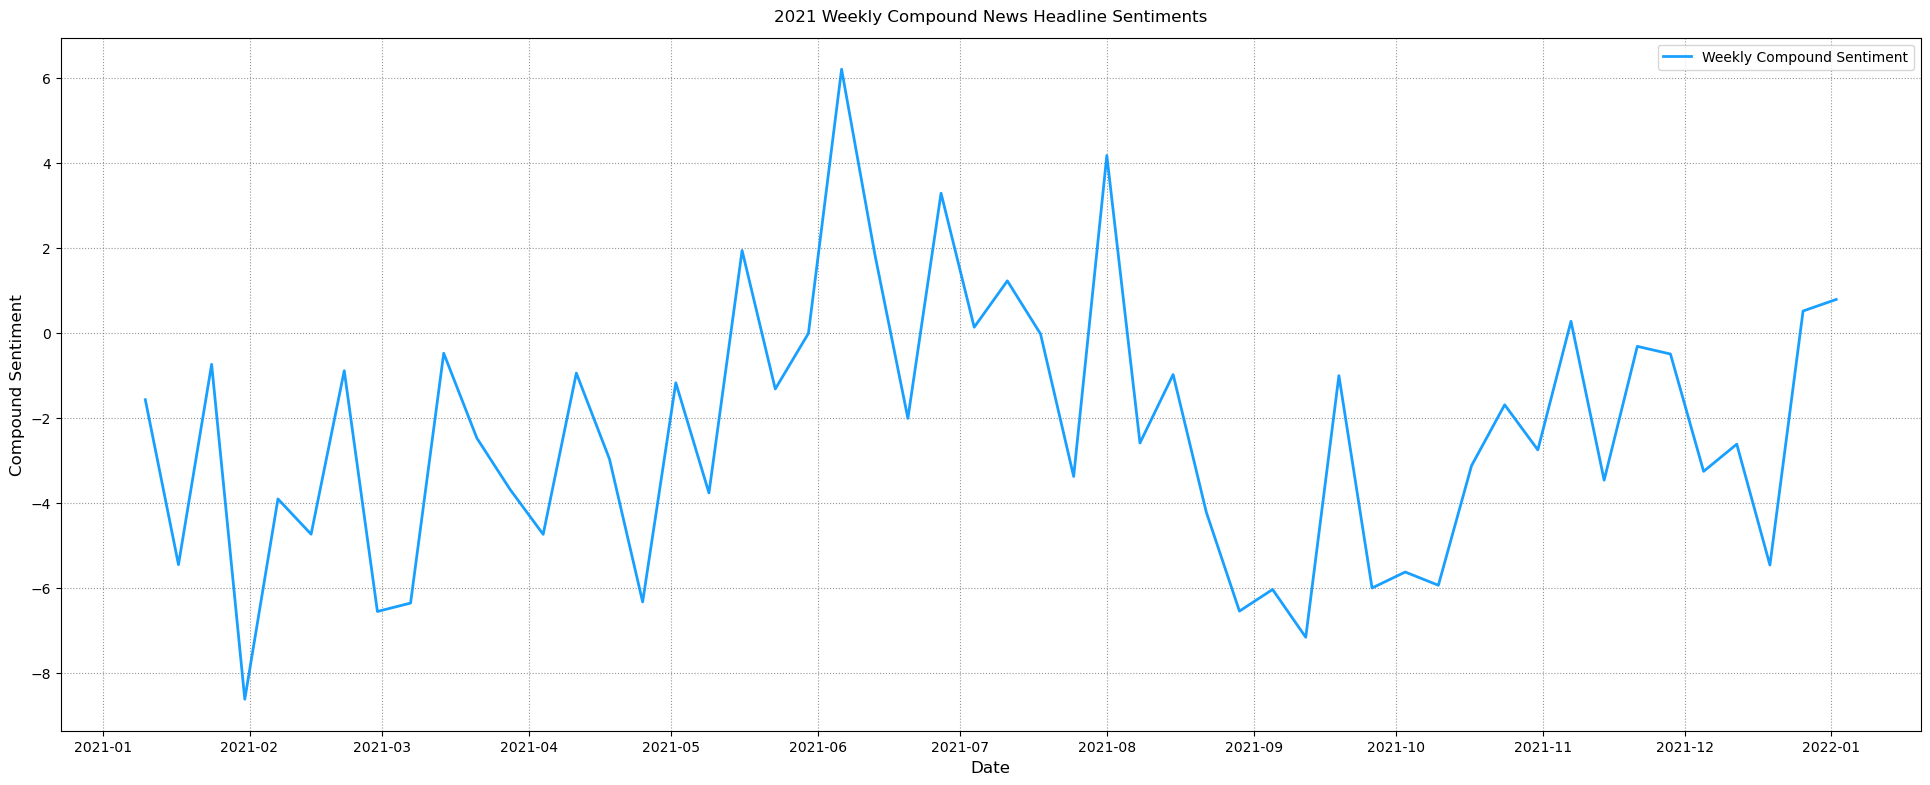

In [40]:
def plot_sentiments_with_events(weekly_df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(24, 9), facecolor='w')

    if year == 2022:
        covid_related = pd.to_datetime(f'{year}-01-23 00:00:00')
        ukraine_war = pd.to_datetime(f'{year}-02-24 00:00:00')
        finland_nato = pd.to_datetime(f'{year}-05-17 00:00:00')
        russia_withdraws = pd.to_datetime(f'{year}-04-06 00:00:00')
        energy_support = pd.to_datetime(f'{year}-09-07 00:00:00')
        domestic_crimes = pd.to_datetime(f'{year}-10-16 00:00:00')
        happy_finland = pd.to_datetime(f'{year}-03-17 00:00:00')

        # Peaks and valleys
        ax.text( x=covid_related - timedelta(days=20), y=-5, s=f'COVID-19 related news', color='#FF0000', fontsize=10)
        ax.text( x=ukraine_war + timedelta(days=5), y=-10, s=f'Russia invades Ukraine', color='#FF0000', fontsize=10)
        ax.text( x=happy_finland + timedelta(days=5), y=5, s=f'Finland ranked happiest country 5th year in a row', color='#2AAA8A', fontsize=10)
        ax.text( x=russia_withdraws + timedelta(days=6), y=-2, s=f'Russia withdraws from Kyiv', color='#2AAA8A', fontsize=10)
        ax.text( x=energy_support + timedelta(days=2), y=3, s=f'Government supports energy sector', color='#2AAA8A', fontsize=10)
        ax.text( x=domestic_crimes + timedelta(days=2), y=-7, s=f'Multiple domestic crime reports', color='#FF0000', fontsize=10)

    ax.plot(weekly_df['date'], weekly_df['compound'], color='#0096FF', marker='', linestyle='-',linewidth=2, markersize=12, alpha=.9)

    # Setting Labels
    ax.set_title( f'{year} Weekly Compound News Headline Sentiments', fontsize=12, pad=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Compound Sentiment', fontsize=12)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    # Legend & Grid
    ax.legend(['Weekly Compound Sentiment'])
    ax.grid(linestyle=':', color='#696969', alpha=0.7)

    plt.show()

plot_sentiments_with_events(weekly_df)